In [1]:
# from beacon.models.model import GNNLatent, GNNLatent_v2, GNNLatent_v3
from beacon.models.losses import *
from beacon.utils.data_formatter import map_images
from beacon.utils.plotting import plot1D, plot2D, plot_scatter
from beacon.utils.manager import Manager
from beacon.models.training_evaluation import *
from pykern.pkcollections import PKDict
from tqdm.notebook import trange
import matplotlib.pyplot as plt
from pykern import pkio, pkjson
import numpy as np
import matplotlib as mpl
import sklearn
import random
import pprint
pp = pprint.PrettyPrinter(indent=5)

/home/vagrant/.pyenv/versions/py3/lib/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


In [2]:
modeldir = '/home/vagrant/jupyter/StaffScratch/mkilpatr/beacon/examples/models/GNNLatent_v2/2024-04-19-22-31'
#modeldir = '/home/vagrant/jupyter/StaffScratch/mkilpatr/beacon/examples/models/GNNLatent_v2/2024-04-18-22-32'
with open(modeldir + '/config.json') as f:
    config = pkjson.load_any(f)
    

In [3]:
config['data_params']['crange_x'] = slice(450, 750)
config['data_params']['crange_y'] = slice(350, 650)

In [ ]:
manager = Manager(
    device="cuda",
    gpu=0,
    
    output_dir=config['output_dir'],
    
    data_params=PKDict(**config['data_params']),
        
    model_params=config['model_params'],
        
    training_params=PKDict(**config['training_params']),
)
manager.data_params.limit = -1
manager.device = 'cuda'
manager.gpu = 0

In [5]:
d = manager.split_dataset(split_size = 0.3)
manager.data_type = d.DEV_TO_STRING

Start converting dataset to graphs


data:   0%|          | 0/600 [00:00<?, ?it/s]

normalize:   0%|          | 0/600 [00:00<?, ?it/s]

In [6]:
d.LATENT_PARAMS = ['_sigma_xp',
                     '_sigma_yp',
                     '_emit_x', 
                     '_emit_y']

In [7]:
import torch
import torch.nn.functional as F

from torch.nn import ReLU, Linear
import torch_geometric.nn as geom_nn
from torch_geometric.utils import to_dense_adj

class Autoencoder(torch.nn.Module):
    def __init__(self, input_shape = 100, latent_space = 10):
        super().__init__()

        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_shape, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, latent_space),
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(latent_space, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, input_shape),
        )

    def forward(self, x):
        latent = self.encoder(x)
        out = self.decoder(latent)
        return out, latent

class GNNLatent_v2(torch.nn.Module):
    def __init__(self, initial_shape = 100, hidden_dims = 64, hidden_dims2 = 64, num_classes = 1, output_shape = 1000, edge_index = None, device = 'cpu', batch_size = 1):
        super().__init__()
        self.device = device
        self.x = torch.Tensor(to_dense_adj(edge_index).numpy()).to(device)
        self.edges = edge_index.to(device)
        #Initial_shape = edge_index.shape[1]
        #img_size = d.x_max
        self.initial_shape = initial_shape
        self.B = batch_size
        self.gcn = geom_nn.GCNConv(initial_shape, hidden_dims, normalize = False)
        self.hid = geom_nn.GCNConv(hidden_dims, hidden_dims2, normalize = False)
        self.out = geom_nn.GCNConv(hidden_dims2, 1, normalize = False)
        self.latent = Autoencoder(initial_shape, num_classes)
        
    def to_cpu(self, array: list):
        for i in array:
            i.cpu()

    def forward(self, x, edge_index, edge_weight):
        initial_shape = x.shape
        x = self.gcn(self.x, edge_index, edge_weight)
        x = self.hid(x, edge_index, edge_weight)
        x = self.out(x, edge_index, edge_weight)
        x = F.relu(x)
        out, latent = self.latent(torch.squeeze(x, dim = 2))

        return torch.squeeze(out, dim = 0), torch.squeeze(x), torch.squeeze(latent, dim = 0)
    
    def predict(self, data, device = 'cpu'):
        mask = data.mask_s.to(self.device)
        weight = data.weight_s[data.mask_s, :]
        weight = weight.to(self.device)
        pred, gcn_out, latent = self(self.x, self.edges[:,mask], weight)
        self.to_cpu([weight, mask])
        return pred, gcn_out, latent

In [8]:
model = GNNLatent_v2(
    initial_shape=d.train[0].num_nodes, 
    num_classes=4, 
    edge_index=d.graph.g.edge_index,
    device=manager.device, 
    batch_size=manager.data_params.batch_size, 
    hidden_dims=1024,
    #num_nodes=d.train[0].num_nodes,
)

In [9]:
torch.manual_seed(manager.training_params.seed) # for reproducibility
model.to('cuda:0')
state = torch.load(modeldir + '/model.pkl', map_location='cuda:0')
model.load_state_dict(state)
model.eval()

GNNLatent_v2(
  (gcn): GCNConv(40000, 1024)
  (hid): GCNConv(1024, 64)
  (out): GCNConv(64, 1)
  (latent): Autoencoder(
    (encoder): Sequential(
      (0): Linear(in_features=40000, out_features=1024, bias=True)
      (1): ReLU()
      (2): Linear(in_features=1024, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=4, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=4, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=1024, bias=True)
      (3): ReLU()
      (4): Linear(in_features=1024, out_features=40000, bias=True)
    )
  )
)

In [10]:
N = 0
data = {'train': d.train,
        'test': d.test,
        'val': d.val,
       }

manager.accuracy = []

In [14]:
latent_eval = np.zeros(shape = (0, 4, 2))
device = 'cuda'
model = model.to(manager.device)
accuracies = []
label = []
for k, v in data.items():
    with trange(len(v), desc='data') as t:
        for N in t:

            pred, _, latent = model.predict(v[N], manager.device)
            acc = sklearn.metrics.r2_score(pred.cpu().detach().numpy(), v[N].intensity_t[:,0])

            latent_eval = np.append(latent_eval, np.dstack((latent.cpu().detach().numpy(), v[N].latent[:4])), axis = 0)

            label.append(k)
            accuracies.append(acc)
            

data:   0%|          | 0/294 [00:00<?, ?it/s]

data:   0%|          | 0/180 [00:00<?, ?it/s]

data:   0%|          | 0/126 [00:00<?, ?it/s]

In [15]:
import pandas as pd
df = pd.DataFrame({'Accuracy': accuracies,
                   'Label': label,
                  d.LATENT_PARAMS[0] + '_predict': latent_eval[:,0,0],
                  d.LATENT_PARAMS[1] + '_predict': latent_eval[:,1,0],
                  d.LATENT_PARAMS[2] + '_predict': latent_eval[:,2,0],
                  d.LATENT_PARAMS[3] + '_predict': latent_eval[:,3,0],
                  d.LATENT_PARAMS[0] + '_truth': latent_eval[:,0,1],
                  d.LATENT_PARAMS[1] + '_truth': latent_eval[:,1,1],
                  d.LATENT_PARAMS[2] + '_truth': latent_eval[:,2,1],
                  d.LATENT_PARAMS[3] + '_truth': latent_eval[:,3,1],})
df.describe()

,Accuracy,_sigma_xp_predict,_sigma_yp_predict,_emit_x_predict,_emit_y_predict,_sigma_xp_truth,_sigma_yp_truth,_emit_x_truth,_emit_y_truth
count,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000
mean,0.975038,0.499334,0.488044,0.499324,0.488035,0.500000,0.500000,0.500000,0.500000
std,0.020036,0.325975,0.316735,0.325972,0.316738,0.319409,0.319409,0.319409,0.319409
min,0.800836,-0.002614,-0.001379,-0.002585,-0.001452,0.000000,0.000000,0.000000,0.000000
25%,0.967541,0.209103,0.206158,0.209092,0.206148,0.222222,0.222222,0.222222,0.222222
50%,0.980783,0.502343,0.485659,0.502333,0.485656,0.500000,0.500000,0.500000,0.500000
75%,0.988107,0.785291,0.765471,0.785277,0.765462,0.777778,0.777778,0.777778,0.777778
max,0.998427,1.034224,1.018058,1.034207,1.018048,1.000000,1.000000,1.000000,1.000000


<Axes: xlabel='Accuracy', ylabel='Count'>

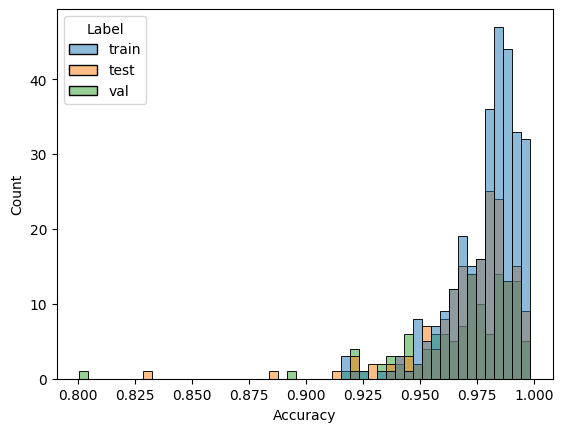

In [16]:
import seaborn as sns
sns.histplot(data = df, x='Accuracy', bins=50, hue='Label')

In [17]:
N = 5
x = d.train[N]
test_pred, _, latent = model.predict(x, manager.device)
reconstruct_ = map_images(test_pred, dim = d.resize)
truth = d.map_images(x, dtype = 'target', gradient = False)
in_sample = d.map_images(x, dtype = 'source', gradient = False)

output path for reconstruct_vs_truth_test.png: models/GNNLatent_v2/2024-07-22-21-17/reconstruct_vs_truth_test.png


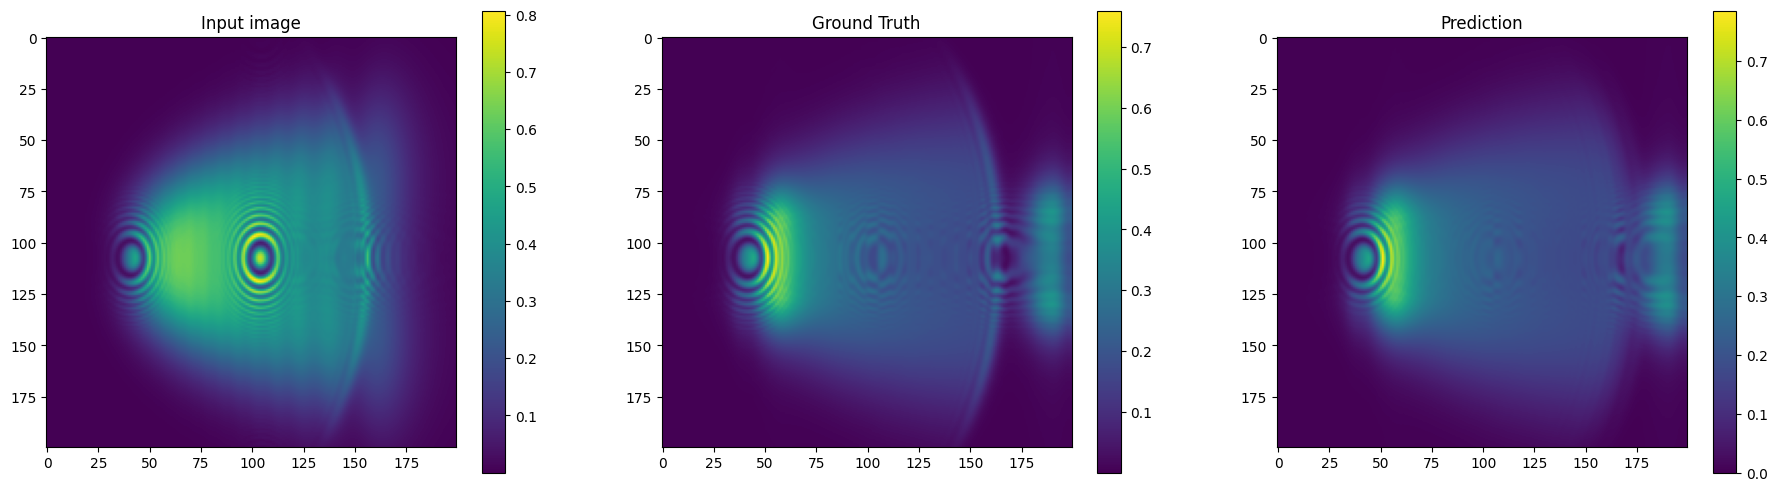

In [18]:
plot2D(
    [in_sample, truth, reconstruct_], 
    ['Input image', 'Ground Truth', 'Prediction'], 
    #title=d.get_title(d.test[N].lut) + str(latent) + ' vs latent truth: ' + str(d.test[N].latent),
    #zlabel = 'Normalized Intensity',
    savefig=manager.plot_path('reconstruct_vs_truth_test.png'),
)

/tmp/ipykernel_144923/1474215147.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap("viridis")
/tmp/ipykernel_144923/1474215147.py:20: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  p = ax[i][2].scatter(x_out.flatten(), y_out.flatten(), s = 2.5, c = cmap(y_out.flatten()), vmin=0, vmax=1)


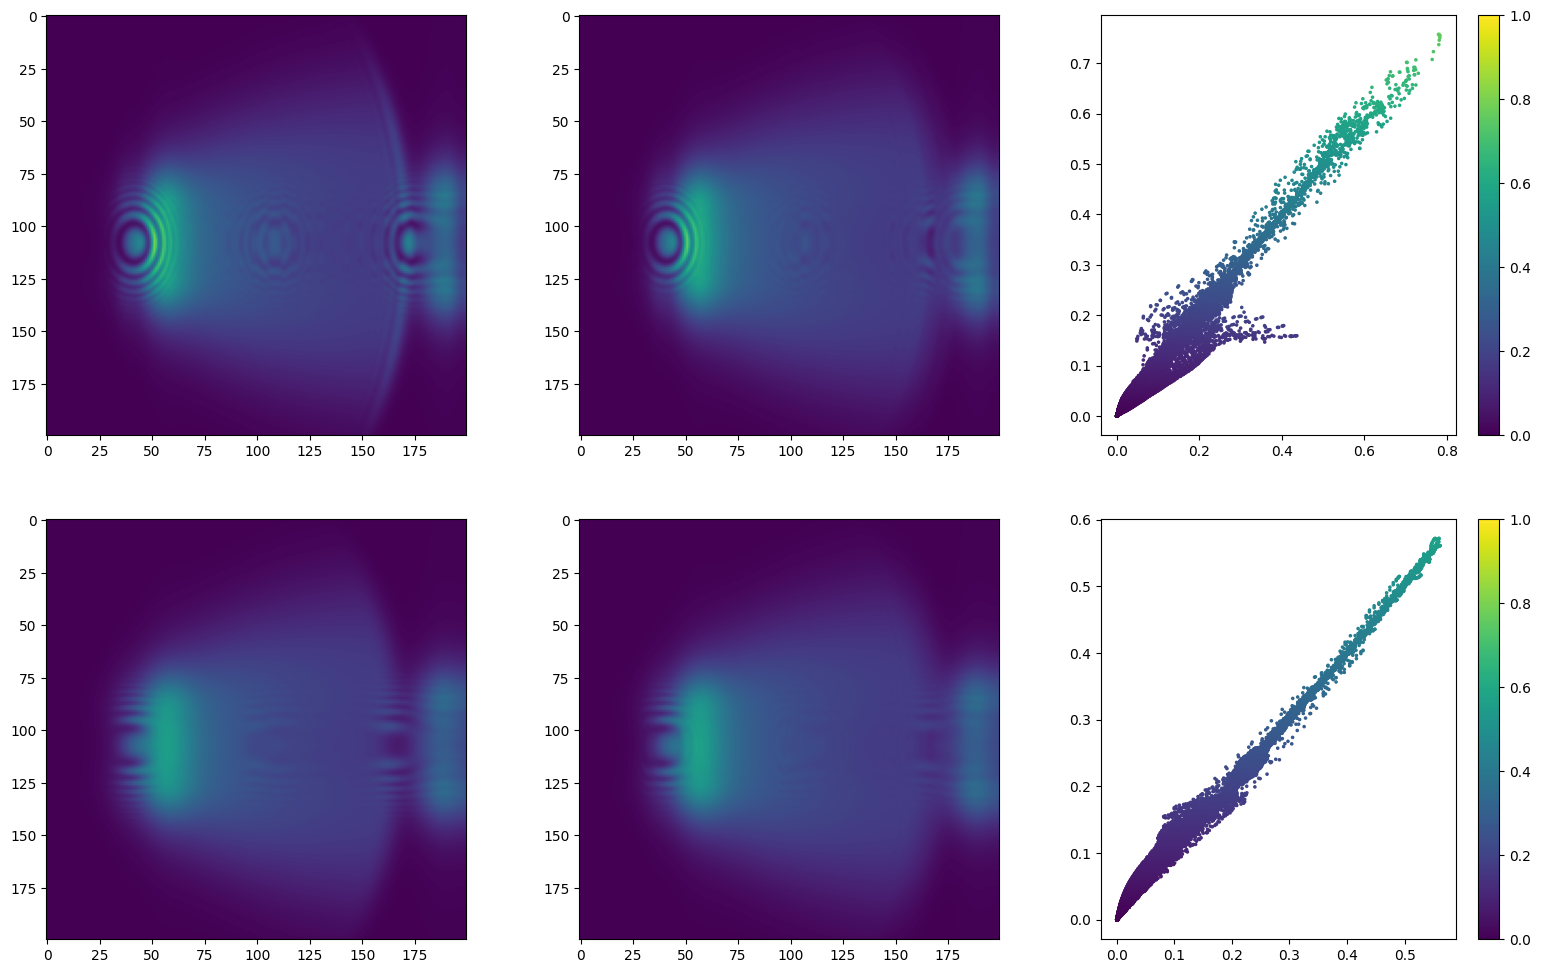

In [19]:
import matplotlib.pyplot as plt
import matplotlib as mpl

#(7.5*N, 6*sample)
sample = 2
N = 3
fig, ax = plt.subplots(sample,N, figsize = (6.5*N, 6*sample))
cmap = mpl.cm.get_cmap("viridis")
cmap.set_bad(color='white')
for i, gx in enumerate(range(sample)):
    gx = random.choice(d.train)
    pred, _, _ = model.predict(gx, manager.device)
    y_out = map_images(pred, dim = d.resize)
    x_out = d.map_images(gx, dtype = 'target', gradient = False)

    p = ax[i][0].imshow(x_out, cmap=cmap, vmin=0, vmax=1)
    
    p = ax[i][1].imshow(y_out, cmap=cmap, vmin=0, vmax=1)

    p = ax[i][2].scatter(x_out.flatten(), y_out.flatten(), s = 2.5, c = cmap(y_out.flatten()), vmin=0, vmax=1)
    cb = fig.colorbar(p, ax=ax[i][2])
    
    if i + 1 == sample:
        fig.show()
        break

In [29]:
import matplotlib.ticker as tck
LATENT_PARAMS = d.LATENT_PARAMS

def uncertainty(df, key):
    df['difference'] = np.abs(df[key + '_truth'] - df[key + '_predict'])
    diff_dn, diff_avg, diff_up = df['difference'].quantile([0.25, 0.5, 0.75])*100
    return np.abs(np.round(diff_avg, decimals = 2)), np.abs(np.round(diff_dn, decimals = 2)), np.abs(np.round(diff_up, decimals = 2))

def plot_scatter(key, log = False, savefig = None, zlabel = ''):
    fig, ax = plt.subplots(figsize = (9, 6))
    cmap = mpl.cm.get_cmap("viridis")
    cmap.set_bad(color='white')
    
    x, y = df[key + '_truth'], df[key + '_predict']
    xname, yname = 'Ground Truth', 'Predicted'
    
    plt.legend()
    legend = {}
    
    for i in ['train', 'test', 'val']:
        uncert, uncert_min, uncert_max = uncertainty(df[df['Label'] == i], key)  
        legend[i] = i + ', error = ' + str(uncert) + '% +' + str(uncert_max) + '/-' + str(uncert_min)
        #ax.scatter(x[df['Label'] == i], y[df['Label'] == i], s = 4.5, label = i + ', error = ' + str(uncert) + '% +' + str(uncert_max) + '/-' + str(uncert_min))

    g = sns.boxplot(x=key + '_truth', y=key + '_predict', hue='Label', palette=['r', 'b', 'g'], data=df)    
    if log:
        ax.set_xscale("log")
        ax.set_yscale("log")
        
    majorFormatter = tck.FormatStrFormatter('%0.4f')
    ax.xaxis.set_major_formatter(majorFormatter)
    ax.set_title('Latent space prediction for beam emittance: ' + zlabel.replace('_', ' '))
    # cb = plt.colorbar()
    # cb.set_label(zlabel, rotation=270)
    ax.set_xlabel(xname)
    ax.set_ylabel(yname)
    handles, _ = ax.get_legend_handles_labels()          # Get the artists.
    ax.legend(handles, [legend['train'], legend['test'], legend['val']], loc="best")
    x_value = -.65    #Offset by eye
    y_value = .92
    plt.tight_layout()
    if savefig is not None:
        plt.savefig(savefig)
        
    plt.show()

/tmp/ipykernel_144923/197889448.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap("viridis")


output path for latent__emit_x.png: models/GNNLatent_v2/2024-07-22-21-17/latent__emit_x.png


/tmp/ipykernel_144923/197889448.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['difference'] = np.abs(df[key + '_truth'] - df[key + '_predict'])
/tmp/ipykernel_144923/197889448.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['difference'] = np.abs(df[key + '_truth'] - df[key + '_predict'])
/tmp/ipykernel_144923/197889448.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

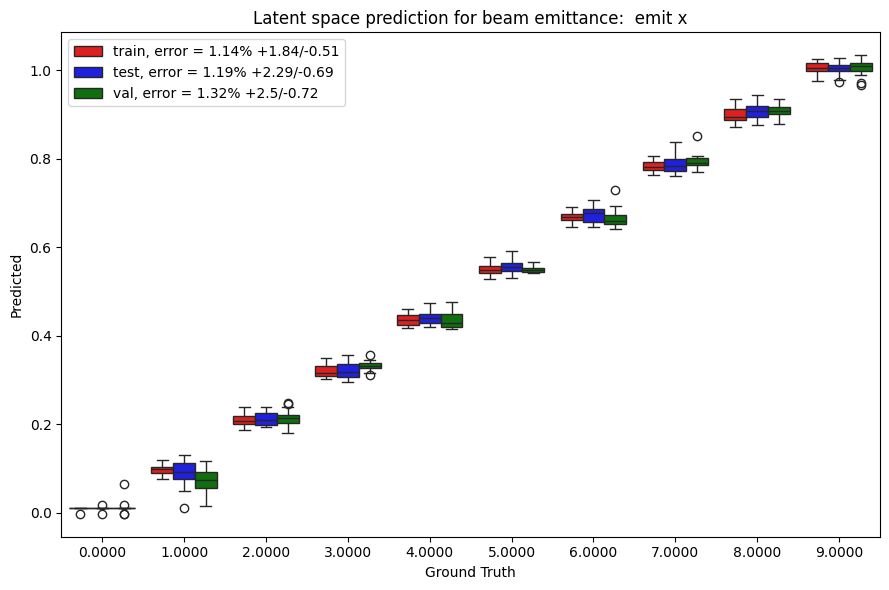

/tmp/ipykernel_144923/197889448.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap("viridis")


output path for latent__emit_y.png: models/GNNLatent_v2/2024-07-22-21-17/latent__emit_y.png


/tmp/ipykernel_144923/197889448.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['difference'] = np.abs(df[key + '_truth'] - df[key + '_predict'])
/tmp/ipykernel_144923/197889448.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['difference'] = np.abs(df[key + '_truth'] - df[key + '_predict'])
/tmp/ipykernel_144923/197889448.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

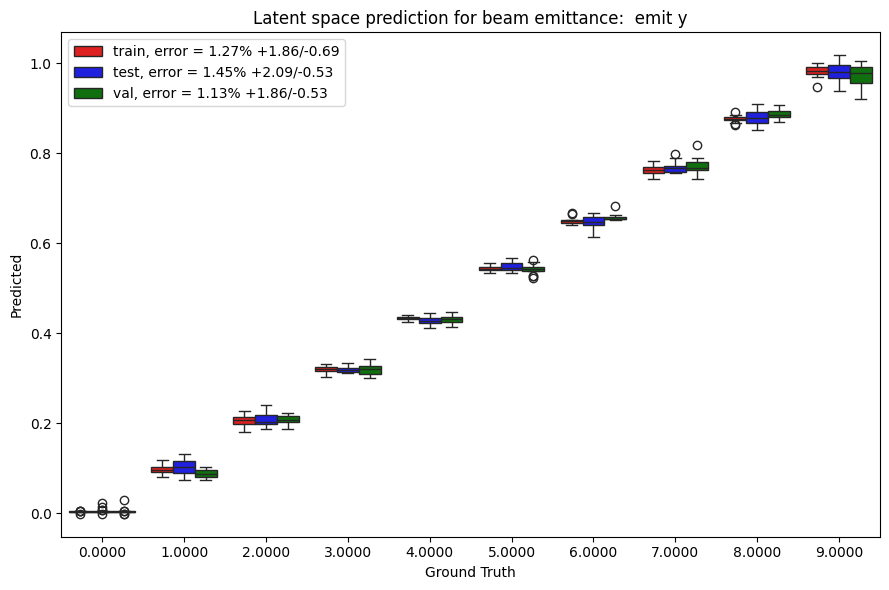

In [30]:
for key in LATENT_PARAMS:
    if '_emit' not in key: continue
    plot_scatter(key, 
                 zlabel=key, 
                 log = False,  
                 savefig = manager.plot_path('latent_' + key + '.png')) 